In [1]:
!pip install torchmetrics==0.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 36.9 MB/s 


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import os

import cv2
from torchmetrics import F1Score
import pickle
from sklearn import manifold
import gzip

TSNE Plots

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for i, data in enumerate(iterator):

            x = data[0].to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(data[1])
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
def get_tsne(data, n_components = 2):

    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [ ]:
def get_dataset_labels(path):
    class_lab = []
    classes = os.listdir(path)
    classes.sort()
    for folder in classes:
        class_lab.append(folder)
    return class_lab

In [ ]:
def plot_representations(data, labels, classes):
                 
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='hsv')
    handles, _ = scatter.legend_elements(prop='colors', num=None)
    ax.legend(handles, classes, loc='best')

**Data Loaders**

---



In [ ]:
def load_data(path_train, val_split, path_test, batch_size, input_size):
  
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    transform_train= transforms.Compose([transforms.Resize(input_size),
                                         transforms.ColorJitter(brightness=(0.5,1.2), contrast=0, saturation=0, hue=0),
                                         transforms.RandomHorizontalFlip(),
#                                          transforms.RandomVerticalFlip(),
                                          transforms.RandomRotation(45),
                                        transforms.RandomAdjustSharpness(0.8),
                                          transforms.ToTensor(),
                                          normalize
                                          ])

    transform_test = transforms.Compose([transforms.Resize(input_size),
                                         transforms.ToTensor(), 
                                         normalize])

    data_train = datasets.ImageFolder(root=path_train, transform=transform_train)
    data_test = datasets.ImageFolder(root=path_test, transform=transform_test)
    
    mappings = data_train.class_to_idx

    val_size = int(len(data_train)*val_split)
    train_size = len(data_train) - val_size

    train_dataset, val_dataset = td.random_split(data_train, [train_size, val_size])
    
    data_loader_train = td.DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      num_workers=0,       
                                      pin_memory=True)
     
    data_loader_val = td.DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=False,
                                    num_workers=0) 
      
    data_loader_test = td.DataLoader(data_test,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=False,
                                   num_workers=0)
    
    return data_loader_train, data_loader_test, data_loader_val, mappings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/My Drive/6721 Project dataset/'
savepath = '/content/drive/My Drive/6721 Dataset/'
modelspath = '/content/drive/My Drive/6721 Project models/After hyperparameter tuning/kaggle/working/'
print(os.listdir(modelspath))

['vgg11model_d3.pt', 'vgg11model_d3_results.pkb', 'resnetmodel_d1.pt', 'vgg11model_d2.pt', 'vgg11model_d1_results.pkb', 'resnetmodel_d3_results.pkb', '__notebook_source__.ipynb', 'resnetmodel_d2_results.pkb', 'resnetmodel_tl_d1.pt', 'alexnetmodel_d2_results.pkb', 'vgg11model_d2_results.pkb', 'vgg11model_d1.pt', 'alexnetmodel_tl_d1_results.pkb', 'resnetmodel_d2.pt', 'alexnetmodel_d3_results.pkb', 'alexnetmodel_d1_results.pkb', '.virtual_documents', 'alexnetmodel_tl_d1.pt', 'alexnetmodel_d1.pt', 'resnetmodel_tl_d1_results.pkb', 'alexnetmodel_d2.pt', 'resnetmodel_d1_results.pkb', 'resnetmodel_d3.pt', 'alexnetmodel_d3.pt']


In [ ]:
path_dataset1 = path+"Indian Traffic Signs Prediction(85 classes)/"
path_dataset2 = path+"Persian Traffic Sign Dataset (PTSD)/"
path_dataset3 = path+"Traffic Signs (GTSRB plus 162 custom classes)/Data_images/"

Architecture 1: AlexNet

On dataset 1:

In [ ]:
nclasses=15

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
AlexNet_model.load_state_dict(torch.load(modelspath+"alexnetmodel_d1.pt"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

trained_AlexNet_model = AlexNet_model

Device: cuda:0


In [ ]:
outputs, labels = get_representations(trained_AlexNet_model, train_loader)

In [ ]:
classes = get_dataset_labels(path_train)

In [ ]:
output_tsne_data = get_tsne(outputs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


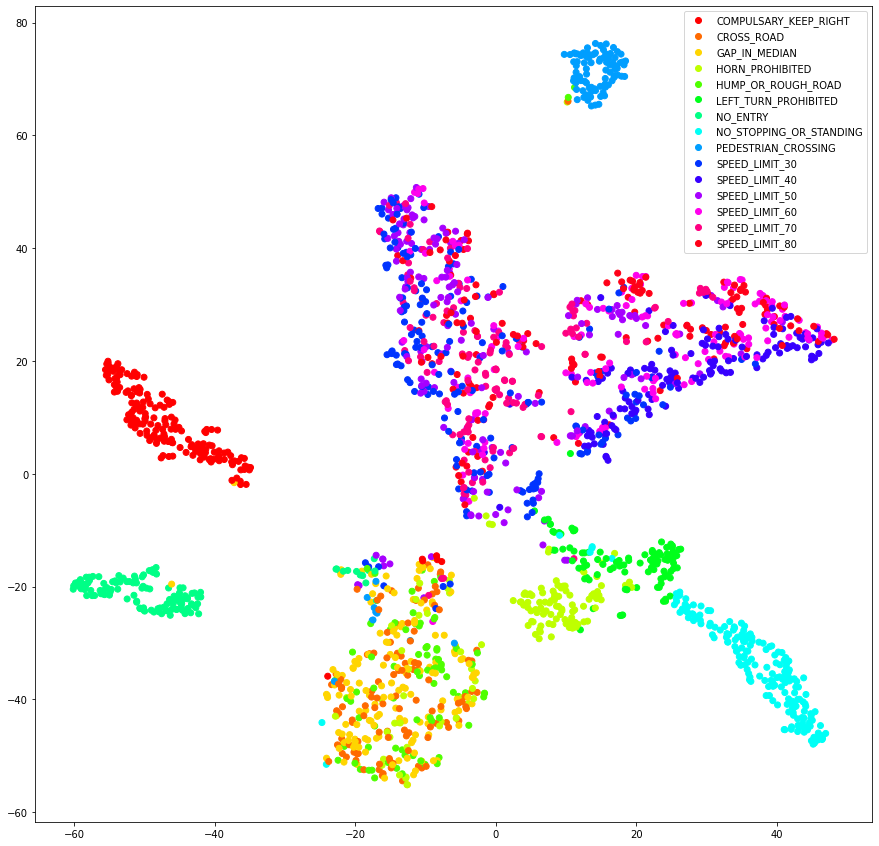

In [ ]:
plot_representations(output_tsne_data, labels, classes)

Transfer Learning Models:

Alexnet with dataset 1

In [ ]:
nclasses=15

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# layers = AlexNet_model.state_dict().keys()

for name, param in AlexNet_model.named_parameters():
    if name.startswith('features'):
        param.requires_grad = False

In [ ]:
prev_out = AlexNet_model.classifier[4].out_features
AlexNet_model.classifier[6] = nn.Linear( prev_out, nclasses)

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
AlexNet_model.load_state_dict(torch.load(modelspath+'alexnetmodel_tl_d1.pt'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = AlexNet_model.to(device)

trained_AlexNet_model = AlexNet_model

Device: cuda:0


In [ ]:
outputs, labels = get_representations(trained_AlexNet_model, train_loader)

In [ ]:
classes = get_dataset_labels(path_train)

In [ ]:
output_tsne_data = get_tsne(outputs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


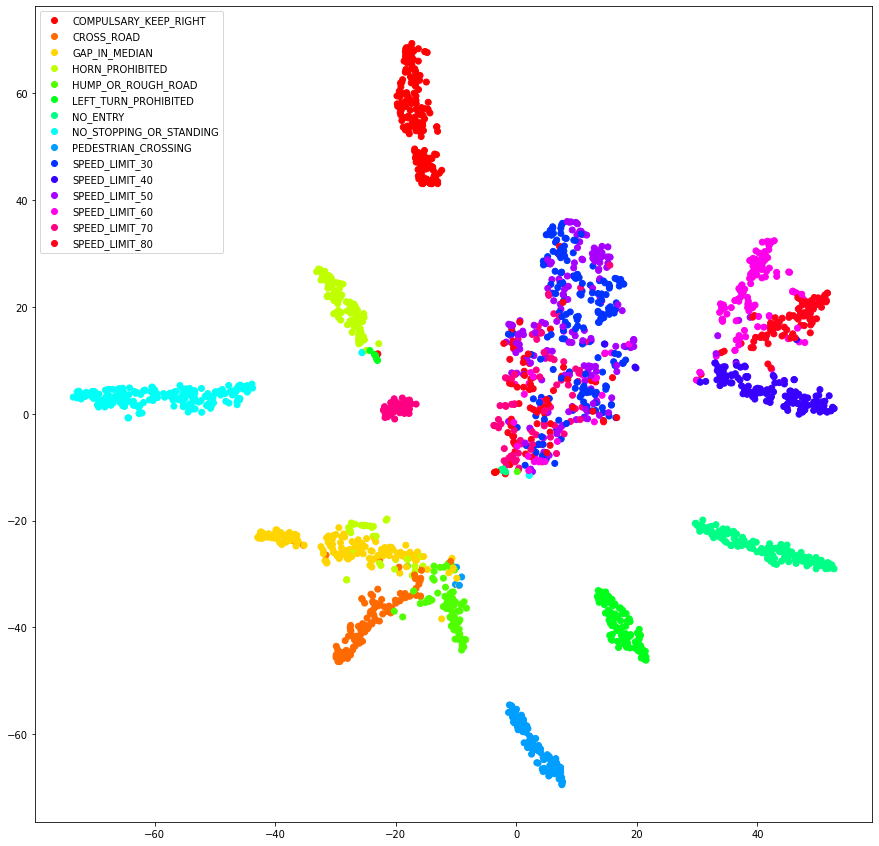

In [ ]:
plot_representations(output_tsne_data, labels, classes)

Architecture 3: ResNet-18

on dataset 1:

In [ ]:
nclasses=15

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
path_train = path_dataset1+"train/"
path_test = path_dataset1+"test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
ResNet_model.load_state_dict(torch.load(modelspath+"resnetmodel_d1.pt"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = ResNet_model.to(device)

trained_ResNet_model = ResNet_model

Device: cuda:0


In [ ]:
outputs, labels = get_representations(trained_ResNet_model , train_loader)

In [ ]:
classes = get_dataset_labels(path_train)

In [ ]:
output_tsne_data = get_tsne(outputs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


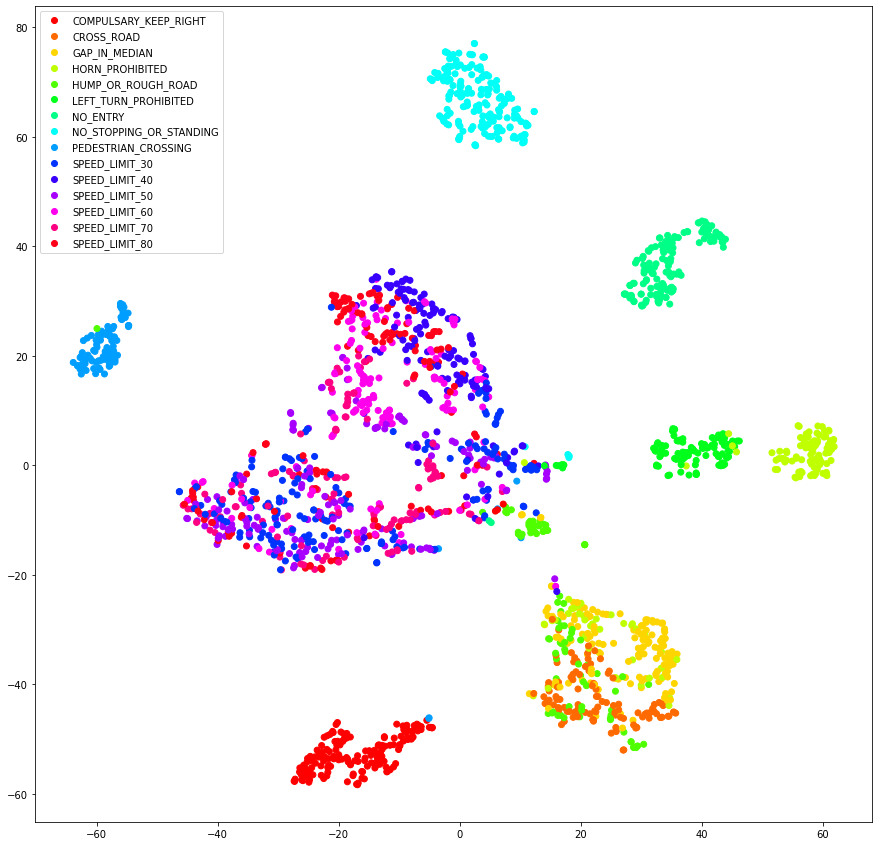

In [ ]:
plot_representations(output_tsne_data, labels, classes)

on dataset 3:

In [ ]:
nclasses=8

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
ResNet_model.fc = nn.Linear( 512, nclasses)

In [ ]:
path_train = path_dataset3+"Train/"
path_test = path_dataset3+"Test/"
val_split = 0.2
batch_size = 32
input_size = (224,224)

train_loader, test_loader, val_loader, mappings = load_data(path_train, val_split, path_test, batch_size, input_size)

In [ ]:
ResNet_model.load_state_dict(torch.load(modelspath+"resnetmodel_d3.pt"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
x = ResNet_model.to(device)

trained_ResNet_model = ResNet_model

Device: cuda:0


In [ ]:
outputs, labels = get_representations(trained_ResNet_model, train_loader)

In [ ]:
classes = get_dataset_labels(path_train)

In [ ]:
output_tsne_data = get_tsne(outputs)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


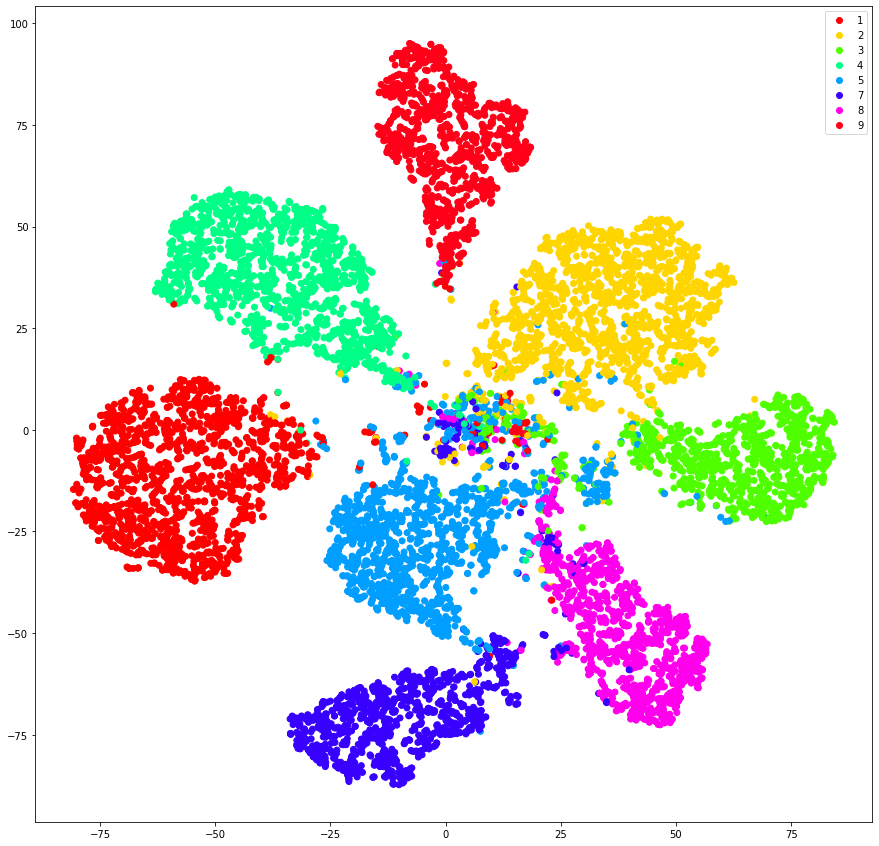

In [ ]:
plot_representations(output_tsne_data, labels, classes)